The image transforms were originally done in MATLAB. From the paper, these transforms were from:

- white balance: Algorithm described in [Enhancing Underwater Images and Videos by Fusion](https://projet.liris.cnrs.fr/imagine/pub/proceedings/CVPR2012/data/papers/011_P1A-11.pdf)
- `adapthisteq` in MATLAB, applied to the L component in the CIELAB color space
- gamma correction of 0.7

Original MATLAB code in `generate_training_data.m`:

```matlab
%%% white balance
hazy_wb = SimplestColorBalance(uint8(255*image1));
hazy_wb = uint8(hazy_wb);
    
%%% CLAHE
lab1 = rgb_to_lab(uint8(255*image1));
lab2 = lab1;
lab2(:, :, 1) = adapthisteq(lab2(:, :, 1));
img2 = lab_to_rgb(lab2);
hazy_cont = img2;

%%% gamma correction
hazy_gamma = image1.^0.7;
hazy_gamma =  uint8(255*hazy_gamma);
```

`rgb_to_lab.m`:

```matlab
function lab = rgb_to_lab(rgb)
cform = makecform('srgb2lab');
lab = applycform(rgb,cform);
```

`lab_to_rgb.m`:

```matlab
function rgb = lab_to_rgb(lab)
cform = makecform('lab2srgb');
rgb = applycform(lab,cform);
```

The code repo had user contributed code for doing them in Python. Looked at it.

In [1]:
import numpy as np
import cv2

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sample_bgr = cv2.imread("../data/bundled/input_train/10_img_.jpg")

In [5]:
sample_rgb = cv2.cvtColor(sample_bgr, cv2.COLOR_BGR2RGB)

In [23]:
true_wb_bgr = cv2.imread("../data/bundled/input_wb_train/10_img_.jpg")
true_he_bgr = cv2.imread("../data/bundled/input_ce_train/10_img_.jpg")
true_gc_bgr = cv2.imread("../data/bundled/input_gc_train/10_img_.jpg")

In [24]:
true_wb_rgb = cv2.cvtColor(true_wb_bgr, cv2.COLOR_BGR2RGB)
true_he_rgb = cv2.cvtColor(true_he_bgr, cv2.COLOR_BGR2RGB)
true_gc_rgb = cv2.cvtColor(true_gc_bgr, cv2.COLOR_BGR2RGB)

## White balance

In [6]:
def white_balance(img, percent=0):
    # Meant to be used on BGR numpy array as uint8
    out_channels = []
    cumstops = (
        img.shape[0] * img.shape[1] * percent / 200.0,
        img.shape[0] * img.shape[1] * (1 - percent / 200.0)
    )
    for channel in cv2.split(img):
        cumhist = np.cumsum(cv2.calcHist([channel], [0], None, [256], (0,256)))
        low_cut, high_cut = np.searchsorted(cumhist, cumstops)
        lut = np.concatenate((
            np.zeros(low_cut),
            np.around(np.linspace(0, 255, high_cut - low_cut + 1)),
            255 * np.ones(255 - high_cut)
        ))
        out_channels.append(cv2.LUT(channel, lut.astype('uint8')))
    img = cv2.merge(out_channels)
    return img

In [7]:
wb_sample = white_balance(sample_bgr, percent=0.5)

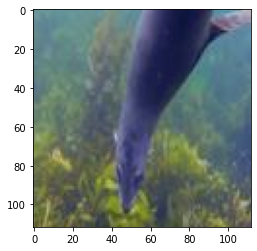

In [9]:
plt.imshow(sample_rgb)

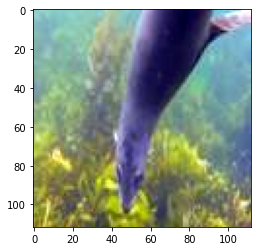

In [10]:
plt.imshow(cv2.cvtColor(wb_sample, cv2.COLOR_BGR2RGB))

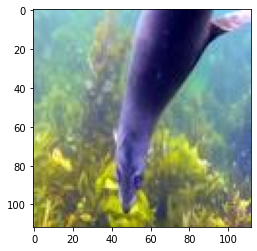

In [26]:
plt.imshow(true_wb_rgb)

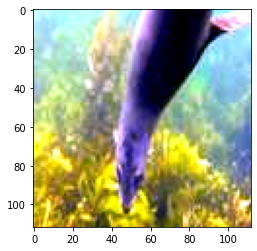

In [12]:
plt.imshow(cv2.cvtColor(white_balance(sample_bgr, percent=15), cv2.COLOR_BGR2RGB))

Did some prelim searching, apparently there isn't a standard method for adjusting white balance. Some histogram matching is required. Thus, no convenient implementations are included in PIL or OpenCV.

This implementation is usable as-is. Not gonna bother with replacing the OpenCV functions to reduce dependencies.

## Histogram Equalization

This was apparently done directly using OpenCV. Found [official docs](https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html) for contrast limiting adaptive HE, which is an improvement upon doing global HE.

Yeah the provided code seems wrong. Should be done in the LAB color space instead of grayscale.

In [29]:
# sample_gray = cv2.cvtColor(sample_bgr, cv2.COLOR_BGR2GRAY)
sample_lab = cv2.cvtColor(sample_bgr, cv2.COLOR_BGR2LAB)

In [30]:
sample_lab.shape

(112, 112, 3)

In [103]:
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe = cv2.createCLAHE(clipLimit=0.01, tileGridSize=(8,8))

Verified from MATLAB docs (https://www.mathworks.com/help/images/ref/adapthisteq.html) that gridsize is specified following MATLAB defaults, but not clip limit. The variables here are straight from one of the examples in the OpenCV docs linked above!

In [97]:
sample_he_l = clahe.apply(sample_lab[:, :, 0])

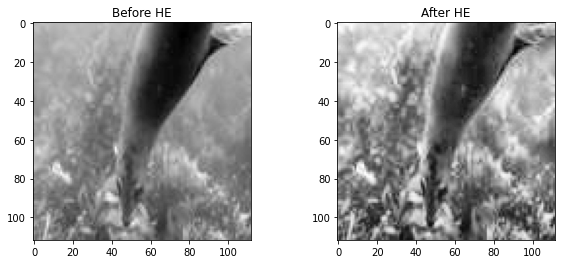

In [98]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

ax[0].imshow(sample_lab[:, :, 0], cmap="gray")
ax[0].set_title("Before HE")

ax[1].imshow(sample_he_l, cmap="gray")
ax[1].set_title("After HE")

plt.show()

In [99]:
sample_he = sample_lab.copy()

In [100]:
sample_he[:, :, 0] = sample_he_l

In [101]:
sample_he_bgr = cv2.cvtColor(sample_he, cv2.COLOR_LAB2BGR)
sample_he_rgb = cv2.cvtColor(sample_he, cv2.COLOR_LAB2RGB)

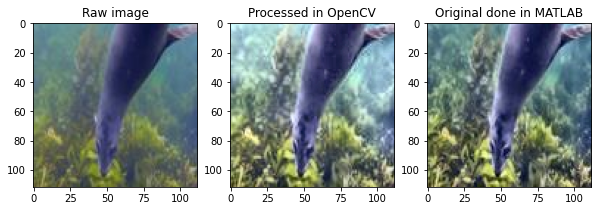

In [102]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 4))

ax[0].imshow(sample_rgb)
ax[0].set_title("Raw image")

ax[1].imshow(sample_he_rgb)
ax[1].set_title("Processed in OpenCV")

ax[2].imshow(true_he_rgb)
ax[2].set_title("Original done in MATLAB")

plt.show()

Even corrected, the results aren't exactly right. Starting to suspect that this user-submitted implementation isn't faithful to the paper author's logic in MATLAB!

In [108]:
candidates = [1e-2, 0.1, 0.5, 1, 2, 3, 4, 6, 10]

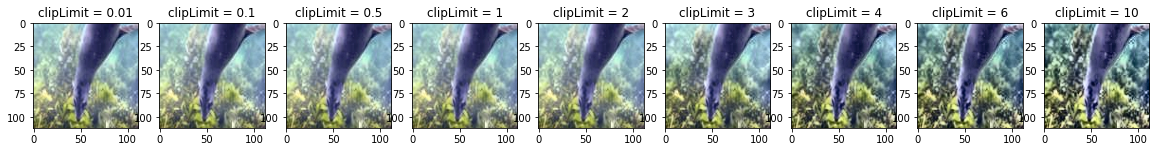

In [109]:
fig, ax = plt.subplots(ncols=len(candidates), figsize=(20, 4))

for count, i in enumerate(candidates):
    clahe = cv2.createCLAHE(clipLimit=i, tileGridSize=(8,8))
    sample_he_l = clahe.apply(sample_lab[:, :, 0])
    
    sample_he = sample_lab.copy()
    sample_he[:, :, 0] = sample_he_l
    sample_he_rgb = cv2.cvtColor(sample_he, cv2.COLOR_LAB2RGB)
    
    ax[count].imshow(sample_he_rgb)
    ax[count].set_title(f"clipLimit = {i}")

plt.show()

Hmm. Tricky. Moving on for now.

## Gamma correction

Python code is provided.

In [111]:
def adjust_gamma(image, gamma=0.7):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [113]:
sample_gc_bgr = adjust_gamma(sample_bgr, 0.7)

In [114]:
sample_gc_rgb = cv2.cvtColor(sample_gc_bgr, cv2.COLOR_BGR2RGB)

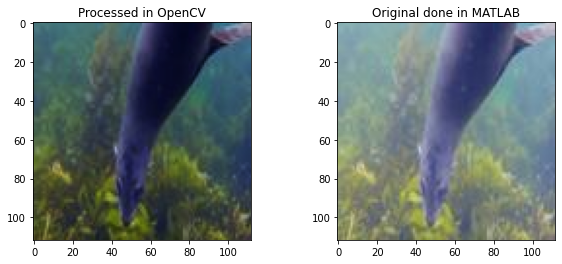

In [116]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

ax[0].imshow(sample_gc_rgb)
ax[0].set_title("Processed in OpenCV")

ax[1].imshow(true_gc_rgb)
ax[1].set_title("Original done in MATLAB")

plt.show()

Wow. Trying this out myself based on the MATLAB source code.

In [119]:
manual_gc = np.power(sample_rgb / 255, 0.7)

In [120]:
manual_gc = np.clip(255 * manual_gc, 0, 255)
manual_gc = manual_gc.astype(np.uint8)

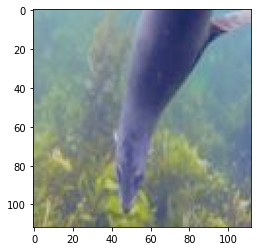

In [121]:
plt.imshow(manual_gc)

Hmm. I think these code chunks were just copy-pasted w/o verification or testing?

Yeah this code chunk is pasted from https://pyimagesearch.com/2015/10/05/opencv-gamma-correction/. Dammit.

## Redoing white balance transform

From the original code, apparently there's a `SimplestColorBalance.m` that I missed. Converting to Python:

```matlab
function outval = SimplestColorBalance(im_org)
num = 255;
% SimplestColorBalance(im_orig, satLevel)
% Performs color balancing via histogram normalization.
% satLevel controls the percentage of pixels to clip to white and black.
% Set plot = 0 or 1 to turn diagnostic plots on or off.
if ndims(im_org) == 3
    
    R = sum(sum(im_org(:,:,1)));
    G = sum(sum(im_org(:,:,2)));
    B = sum(sum(im_org(:,:,3)));
    Max = max([R, G, B]);
    ratio = [Max / R, Max / G, Max / B];

    satLevel1 = 0.005 * ratio;
    satLevel2 = 0.005 * ratio;
    
    [m, n, p] = size(im_org);
    imRGB_orig = zeros(p, m * n);
    for i = 1 : p
        imRGB_orig(i, :) = reshape(double(im_org(:, :, i)), [1, m * n]);
        %imRGB_orig(i, :) = imRGB_orig(i, :) / max(imRGB_orig(i, :)) * 255;
    end
else
    
    satLevel1 = 0.001;
    satLevel2 = 0.005;
    [m, n] = size(im_org);
    p = 1;
    imRGB_orig = reshape(double(im_org), [1, m * n]);
    %imRGB_orig = imRGB_orig / max(imRGB_orig) * 255;
end
% full width histogram method
% percentage of the image to saturate to black or white, tweakable param
imRGB = zeros(size(imRGB_orig));
for ch = 1 : p
    q = [satLevel1(ch), 1 - satLevel2(ch)];
    tiles = quantile(imRGB_orig(ch, :), q);
    temp = imRGB_orig(ch, :);
    temp(find(temp < tiles(1))) = tiles(1);
    temp(find(temp > tiles(2))) = tiles(2);
    imRGB(ch, :) = temp;
    bottom = min(imRGB(ch, :)); 
    top = max(imRGB(ch, :));
    imRGB(ch, :) = (imRGB(ch, :) - bottom) * num / (top - bottom); 
end
if ndims(im_org) == 3
    outval = zeros(size(im_org));
    for i = 1 : p
        outval(:, :, i) = reshape(imRGB(i, :), [m, n]); 
    end
else
    outval = reshape(imRGB, [m, n]); 
end
outval = uint8(outval);
%imshow([im_orig,uint8(outval)])
```

In [132]:
def simplest_color_balance(arr):
    # Requires HWC uint8 input

    # This section basically reshapes into vectors per channel I think?
   
    # if RGB
    if len(arr.shape) == 3:
        R = np.sum(arr[:, :, 0], axis=None)
        G = np.sum(arr[:, :, 1], axis=None)
        B = np.sum(arr[:, :, 2], axis=None)
        
        maxpix = max(R, G, B)
        ratio = np.array([maxpix / R, maxpix / G, maxpix / B])

        satLevel1 = 0.005 * ratio
        satLevel2 = 0.005 * ratio

        m, n, p = arr.shape
        im_rgb_orig = np.zeros(shape=(p, m * n))
        for i in range(0, p):
            im_rgb_orig[i, :] = np.reshape(arr[:, :, i], (1, m * n))

    # if grayscale
    else:
        satLevel1 = np.array([0.001])
        satLevel2 = np.array([0.005])
        m, n = arr.shape
        p = 1
        im_rgb_orig = np.reshape(arr, (1, m * n))
        
    im_rgb = np.zeros(shape=im_rgb_orig.shape)
    for ch in range(p):
        q = [satLevel1[ch], 1 - satLevel2[ch]]
        tiles = np.quantile(im_rgb_orig[ch, :], q)
        temp = im_rgb_orig[ch, :]
        temp[temp < tiles[0]] = tiles[0]
        temp[temp > tiles[1]] = tiles[1]
        im_rgb[ch, :] = temp
        bottom = min(im_rgb[ch, :])
        top = max(im_rgb[ch, :])
        im_rgb[ch, :] = (im_rgb[ch, :] - bottom) * 255 / (top - bottom)
        
    if len(arr.shape) == 3:
        outval = np.zeros(shape=arr.shape);
        for i in range(p):
            outval[:, :, i] = np.reshape(im_rgb[i, :], (m, n)); 

    else:
        outval = np.reshape(im_rgb, (m, n))
    
    return outval.astype(np.uint8)

Can barely read MATLAB, but I read English and I remember that arrays start at 1. And that's enough.

In [133]:
manual_wb = simplest_color_balance(sample_rgb)

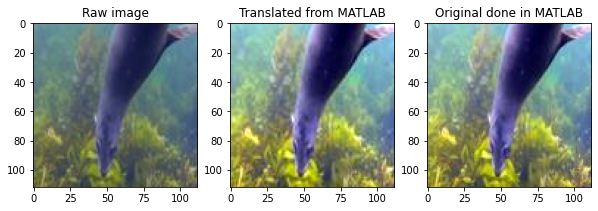

In [134]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 4))

ax[0].imshow(sample_rgb)
ax[0].set_title("Raw image")

ax[1].imshow(manual_wb)
ax[1].set_title("Translated from MATLAB")

ax[2].imshow(true_wb_rgb)
ax[2].set_title("Original done in MATLAB")

plt.show()

There we go. 

## Redoing histogram equalization

The MATLAB code uses conversions between LAB and SRGB. Google gave me results full of photography blogs talking about SRGB vs RGB. 

From MATLAB docs (https://www.mathworks.com/help/images/understanding-color-spaces-and-color-space-conversion.html), found what I'm looking for. SRGB is RGB with an added layer of gamma correction. The functions are given in the docs.

It looks like the computer vision and image processing community doesn't pay much attention to RGB vs SRGB. OpenCV has an open issue on it: https://github.com/opencv/opencv/issues/18813. 

Anyway. If I can't match the MATLAB output, I know where next to look.

In [135]:
sample_lab = cv2.cvtColor(sample_bgr, cv2.COLOR_BGR2LAB)

In [137]:
sample_he = sample_lab.copy()

Here is where my hands are sorta tied. `adapthisteq` is CLAHE, but OpenCV's implementation doesn't have the same argumnets to tweak like MATLAB's. 

In [136]:
# TODO

Should verify all of these images at scale.